# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count', 'synonyms_count',
                  'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

## 2 Susceptibility in absolute and sentence-relative values

Build our data.

In [3]:
model = Model(time=Time.discrete, source=Source.majority, past=Past.last_bin, durl=Durl.all, max_distance=2)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        # Prepare these arrays for stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        
        for feature in Substitution.__features__:
            sentence_values, _ = substitution.source_destination_features(feature)
            sentence_values_rel, _ = substitution.source_destination_features(
                feature, sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            # Stopword-check the arrays.
            words = getattr(substitution.source, source_type)[dslice]
            for i, (word, lemma, token, tag) in enumerate(zip(words, lemmas, tokens, tags)):
                if (token in stopwords) or (lemma in stopwords):
                    # Drop stopwords from this analysis since we exclude stopword-substitutions.
                    continue
                data.append({'cluster_id': substitution.source.cluster.sid,
                             'destination_id': substitution.destination.sid,
                             'occurrence': substitution.occurrence,
                             'source_id': substitution.source.sid,
                             'feature': feature,
                             'word': word,
                             'POS': tag,
                             'target': i == substitution.position,
                             'value': sentence_values[i],
                             'value_rel': sentence_values_rel[i]})

original_susties = pd.DataFrame(data)
del data

Got 9180 substitutions for model Model(time=Time.discrete, source=Source.majority, past=Past.last_bin, durl=Durl.all, max_distance=2)


  0% (   1 of 9180) |                     | Elapsed Time: 0:00:06 ETA:  16:56:21

  0% (  23 of 9180) |                      | Elapsed Time: 0:00:07 ETA:  0:06:54

  0% (  40 of 9180) |                      | Elapsed Time: 0:00:09 ETA:  0:09:43

  0% (  78 of 9180) |                      | Elapsed Time: 0:00:10 ETA:  0:07:07

  0% (  88 of 9180) |                      | Elapsed Time: 0:00:11 ETA:  0:08:46

  1% ( 110 of 9180) |                      | Elapsed Time: 0:00:12 ETA:  0:08:24

  1% ( 115 of 9180) |                      | Elapsed Time: 0:00:13 ETA:  0:08:22

  1% ( 149 of 9180) |                      | Elapsed Time: 0:00:14 ETA:  0:07:46

  1% ( 174 of 9180) |                      | Elapsed Time: 0:00:15 ETA:  0:07:32

  2% ( 210 of 9180) |                      | Elapsed Time: 0:00:16 ETA:  0:06:55

  2% ( 230 of 9180) |                      | Elapsed Time: 0:00:16 ETA:  0:06:27

  3% ( 280 of 9180) |                      | Elapsed Time: 0:00:17 ETA:  0:05:11

  3% ( 345 of 9180) |                      | Elapsed Time: 0:00:18 ETA:  0:04:21

  4% ( 435 of 9180) |#                     | Elapsed Time: 0:00:19 ETA:  0:03:05

  5% ( 459 of 9180) |#                     | Elapsed Time: 0:00:19 ETA:  0:02:42

  5% ( 510 of 9180) |#                     | Elapsed Time: 0:00:20 ETA:  0:02:38

  6% ( 574 of 9180) |#                     | Elapsed Time: 0:00:21 ETA:  0:02:05

  6% ( 602 of 9180) |#                     | Elapsed Time: 0:00:22 ETA:  0:02:08

  7% ( 689 of 9180) |#                     | Elapsed Time: 0:00:23 ETA:  0:01:58

  8% ( 783 of 9180) |#                     | Elapsed Time: 0:00:24 ETA:  0:01:45

  8% ( 804 of 9180) |#                     | Elapsed Time: 0:00:25 ETA:  0:01:47

  9% ( 903 of 9180) |##                    | Elapsed Time: 0:00:26 ETA:  0:01:44

 10% ( 918 of 9180) |##                    | Elapsed Time: 0:00:26 ETA:  0:01:46

 10% ( 956 of 9180) |##                    | Elapsed Time: 0:00:27 ETA:  0:01:48

 10% (1002 of 9180) |##                    | Elapsed Time: 0:00:28 ETA:  0:01:51

 11% (1033 of 9180) |##                    | Elapsed Time: 0:00:29 ETA:  0:01:53

 11% (1087 of 9180) |##                    | Elapsed Time: 0:00:30 ETA:  0:01:45

 12% (1148 of 9180) |##                    | Elapsed Time: 0:00:30 ETA:  0:01:51

 13% (1231 of 9180) |##                    | Elapsed Time: 0:00:31 ETA:  0:01:53

 13% (1263 of 9180) |###                   | Elapsed Time: 0:00:32 ETA:  0:01:51

 14% (1304 of 9180) |###                   | Elapsed Time: 0:00:33 ETA:  0:02:16

 15% (1377 of 9180) |###                   | Elapsed Time: 0:00:34 ETA:  0:02:06

 15% (1440 of 9180) |###                   | Elapsed Time: 0:00:35 ETA:  0:01:57

 15% (1466 of 9180) |###                   | Elapsed Time: 0:00:36 ETA:  0:02:04

 16% (1492 of 9180) |###                   | Elapsed Time: 0:00:37 ETA:  0:02:11

 16% (1538 of 9180) |###                   | Elapsed Time: 0:00:38 ETA:  0:02:12

 17% (1607 of 9180) |###                   | Elapsed Time: 0:00:39 ETA:  0:02:24

 18% (1675 of 9180) |####                  | Elapsed Time: 0:00:40 ETA:  0:02:22

 18% (1722 of 9180) |####                  | Elapsed Time: 0:00:41 ETA:  0:02:07

 19% (1813 of 9180) |####                  | Elapsed Time: 0:00:42 ETA:  0:02:03

 20% (1836 of 9180) |####                  | Elapsed Time: 0:00:42 ETA:  0:02:04

 20% (1903 of 9180) |####                  | Elapsed Time: 0:00:43 ETA:  0:01:45

 21% (1951 of 9180) |####                  | Elapsed Time: 0:00:44 ETA:  0:01:30

 21% (2018 of 9180) |####                  | Elapsed Time: 0:00:45 ETA:  0:01:23

 22% (2066 of 9180) |####                  | Elapsed Time: 0:00:45 ETA:  0:01:19

 23% (2156 of 9180) |#####                 | Elapsed Time: 0:00:46 ETA:  0:01:14

 23% (2181 of 9180) |#####                 | Elapsed Time: 0:00:47 ETA:  0:01:10

 24% (2241 of 9180) |#####                 | Elapsed Time: 0:00:48 ETA:  0:01:11

 25% (2295 of 9180) |#####                 | Elapsed Time: 0:00:48 ETA:  0:01:13

 25% (2367 of 9180) |#####                 | Elapsed Time: 0:00:49 ETA:  0:01:12

 26% (2410 of 9180) |#####                 | Elapsed Time: 0:00:50 ETA:  0:01:10

 26% (2474 of 9180) |#####                 | Elapsed Time: 0:00:51 ETA:  0:01:14

 27% (2525 of 9180) |######                | Elapsed Time: 0:00:52 ETA:  0:01:20

 28% (2603 of 9180) |######                | Elapsed Time: 0:00:53 ETA:  0:01:23

 28% (2640 of 9180) |######                | Elapsed Time: 0:00:54 ETA:  0:01:25

 29% (2717 of 9180) |######                | Elapsed Time: 0:00:55 ETA:  0:01:19

 30% (2754 of 9180) |######                | Elapsed Time: 0:00:55 ETA:  0:01:22

 30% (2845 of 9180) |######                | Elapsed Time: 0:00:56 ETA:  0:01:15

 31% (2869 of 9180) |######                | Elapsed Time: 0:00:56 ETA:  0:01:14

 32% (2952 of 9180) |#######               | Elapsed Time: 0:00:57 ETA:  0:01:07

 32% (2984 of 9180) |#######               | Elapsed Time: 0:00:58 ETA:  0:01:06

 33% (3060 of 9180) |#######               | Elapsed Time: 0:00:59 ETA:  0:01:05

 33% (3099 of 9180) |#######               | Elapsed Time: 0:01:00 ETA:  0:01:05

 34% (3183 of 9180) |#######               | Elapsed Time: 0:01:01 ETA:  0:01:01

 35% (3213 of 9180) |#######               | Elapsed Time: 0:01:01 ETA:  0:01:04

 35% (3269 of 9180) |#######               | Elapsed Time: 0:01:02 ETA:  0:01:06

 36% (3328 of 9180) |#######               | Elapsed Time: 0:01:03 ETA:  0:01:11

 37% (3420 of 9180) |########              | Elapsed Time: 0:01:04 ETA:  0:01:05

 37% (3443 of 9180) |########              | Elapsed Time: 0:01:04 ETA:  0:01:07

 38% (3523 of 9180) |########              | Elapsed Time: 0:01:05 ETA:  0:00:57

 38% (3558 of 9180) |########              | Elapsed Time: 0:01:06 ETA:  0:00:57

 39% (3639 of 9180) |########              | Elapsed Time: 0:01:07 ETA:  0:00:54

 40% (3672 of 9180) |########              | Elapsed Time: 0:01:07 ETA:  0:00:55

 40% (3757 of 9180) |#########             | Elapsed Time: 0:01:08 ETA:  0:00:48

 41% (3787 of 9180) |#########             | Elapsed Time: 0:01:09 ETA:  0:00:43

 42% (3872 of 9180) |#########             | Elapsed Time: 0:01:10 ETA:  0:00:39

 42% (3902 of 9180) |#########             | Elapsed Time: 0:01:10 ETA:  0:00:42

 43% (3969 of 9180) |#########             | Elapsed Time: 0:01:11 ETA:  0:00:45

 43% (4017 of 9180) |#########             | Elapsed Time: 0:01:12 ETA:  0:00:45

 44% (4106 of 9180) |#########             | Elapsed Time: 0:01:13 ETA:  0:00:42

 45% (4131 of 9180) |#########             | Elapsed Time: 0:01:13 ETA:  0:00:44

 45% (4218 of 9180) |##########            | Elapsed Time: 0:01:14 ETA:  0:00:41

 46% (4246 of 9180) |##########            | Elapsed Time: 0:01:15 ETA:  0:00:41

 47% (4323 of 9180) |##########            | Elapsed Time: 0:01:16 ETA:  0:00:41

 47% (4361 of 9180) |##########            | Elapsed Time: 0:01:16 ETA:  0:00:41

 48% (4437 of 9180) |##########            | Elapsed Time: 0:01:17 ETA:  0:00:39

 48% (4476 of 9180) |##########            | Elapsed Time: 0:01:17 ETA:  0:00:34

 49% (4565 of 9180) |##########            | Elapsed Time: 0:01:18 ETA:  0:00:31

 50% (4590 of 9180) |###########           | Elapsed Time: 0:01:19 ETA:  0:00:31

 50% (4678 of 9180) |###########           | Elapsed Time: 0:01:20 ETA:  0:00:28

 51% (4705 of 9180) |###########           | Elapsed Time: 0:01:20 ETA:  0:00:28

 52% (4784 of 9180) |###########           | Elapsed Time: 0:01:21 ETA:  0:00:28

 52% (4820 of 9180) |###########           | Elapsed Time: 0:01:21 ETA:  0:00:26

 53% (4910 of 9180) |###########           | Elapsed Time: 0:01:22 ETA:  0:00:25

 53% (4935 of 9180) |###########           | Elapsed Time: 0:01:23 ETA:  0:00:22

 54% (5021 of 9180) |############          | Elapsed Time: 0:01:24 ETA:  0:00:22

 55% (5049 of 9180) |############          | Elapsed Time: 0:01:24 ETA:  0:00:23

 55% (5132 of 9180) |############          | Elapsed Time: 0:01:25 ETA:  0:00:22

 56% (5164 of 9180) |############          | Elapsed Time: 0:01:26 ETA:  0:00:26

 57% (5237 of 9180) |############          | Elapsed Time: 0:01:27 ETA:  0:00:27

 57% (5279 of 9180) |############          | Elapsed Time: 0:01:27 ETA:  0:00:26

 58% (5334 of 9180) |############          | Elapsed Time: 0:01:29 ETA:  0:00:37

 58% (5394 of 9180) |############          | Elapsed Time: 0:01:30 ETA:  0:00:44

 59% (5462 of 9180) |#############         | Elapsed Time: 0:01:31 ETA:  0:00:45

 60% (5508 of 9180) |#############         | Elapsed Time: 0:01:31 ETA:  0:00:49

 60% (5589 of 9180) |#############         | Elapsed Time: 0:01:32 ETA:  0:00:45

 61% (5623 of 9180) |#############         | Elapsed Time: 0:01:33 ETA:  0:00:48

 61% (5685 of 9180) |#############         | Elapsed Time: 0:01:34 ETA:  0:00:47

 62% (5738 of 9180) |#############         | Elapsed Time: 0:01:34 ETA:  0:00:46

 63% (5808 of 9180) |#############         | Elapsed Time: 0:01:35 ETA:  0:00:47

 63% (5853 of 9180) |##############        | Elapsed Time: 0:01:36 ETA:  0:00:35

 64% (5936 of 9180) |##############        | Elapsed Time: 0:01:37 ETA:  0:00:29

 65% (5967 of 9180) |##############        | Elapsed Time: 0:01:37 ETA:  0:00:28

 65% (6035 of 9180) |##############        | Elapsed Time: 0:01:38 ETA:  0:00:28

 66% (6082 of 9180) |##############        | Elapsed Time: 0:01:39 ETA:  0:00:27

 67% (6158 of 9180) |##############        | Elapsed Time: 0:01:40 ETA:  0:00:26

 67% (6197 of 9180) |##############        | Elapsed Time: 0:01:41 ETA:  0:00:22

 68% (6264 of 9180) |###############       | Elapsed Time: 0:01:42 ETA:  0:00:22

 68% (6312 of 9180) |###############       | Elapsed Time: 0:01:42 ETA:  0:00:23

 69% (6393 of 9180) |###############       | Elapsed Time: 0:01:43 ETA:  0:00:20

 70% (6426 of 9180) |###############       | Elapsed Time: 0:01:44 ETA:  0:00:20

 70% (6497 of 9180) |###############       | Elapsed Time: 0:01:45 ETA:  0:00:18

 71% (6541 of 9180) |###############       | Elapsed Time: 0:01:45 ETA:  0:00:15

 72% (6627 of 9180) |###############       | Elapsed Time: 0:01:46 ETA:  0:00:14

 72% (6656 of 9180) |###############       | Elapsed Time: 0:01:47 ETA:  0:00:12

 73% (6729 of 9180) |################      | Elapsed Time: 0:01:48 ETA:  0:00:13

 73% (6771 of 9180) |################      | Elapsed Time: 0:01:48 ETA:  0:00:09

 74% (6849 of 9180) |################      | Elapsed Time: 0:01:49 ETA:  0:00:05

 75% (6885 of 9180) |################      | Elapsed Time: 0:01:50 ETA:  0:00:07

 75% (6959 of 9180) |################      | Elapsed Time: 0:01:51 ETA:  0:00:09

 76% (7000 of 9180) |################      | Elapsed Time: 0:01:51 ETA:  0:00:08

 76% (7034 of 9180) |################      | Elapsed Time: 0:01:53 ETA:  0:00:27

 77% (7069 of 9180) |################      | Elapsed Time: 0:01:54 ETA:  0:00:41

 77% (7115 of 9180) |#################     | Elapsed Time: 0:01:54 ETA:  0:00:38

 78% (7197 of 9180) |#################     | Elapsed Time: 0:01:55 ETA:  0:00:34

 78% (7230 of 9180) |#################     | Elapsed Time: 0:01:56 ETA:  0:00:34

 79% (7314 of 9180) |#################     | Elapsed Time: 0:01:57 ETA:  0:00:31

 80% (7344 of 9180) |#################     | Elapsed Time: 0:01:57 ETA:  0:00:35

 80% (7402 of 9180) |#################     | Elapsed Time: 0:01:58 ETA:  0:00:38

 81% (7459 of 9180) |#################     | Elapsed Time: 0:01:59 ETA:  0:00:33

 82% (7540 of 9180) |##################    | Elapsed Time: 0:02:00 ETA:  0:00:09

 82% (7574 of 9180) |##################    | Elapsed Time: 0:02:00 ETA:  0:00:00

 83% (7656 of 9180) |##################    | Elapsed Time: 0:02:01 ETA:  0:00:00

 83% (7689 of 9180) |##################    | Elapsed Time: 0:02:02 ETA:  0:00:00

 84% (7783 of 9180) |##################    | Elapsed Time: 0:02:03 ETA:  0:00:00

 85% (7803 of 9180) |##################    | Elapsed Time: 0:02:03 ETA:  0:00:00

 85% (7893 of 9180) |##################    | Elapsed Time: 0:02:04 ETA:  0:00:00

 86% (7918 of 9180) |##################    | Elapsed Time: 0:02:04 ETA:  0:00:00

 87% (7994 of 9180) |###################   | Elapsed Time: 0:02:06 ETA:  0:00:00

 87% (8033 of 9180) |###################   | Elapsed Time: 0:02:06 ETA:  0:00:00

 88% (8113 of 9180) |###################   | Elapsed Time: 0:02:07 ETA:  0:00:00

 88% (8148 of 9180) |###################   | Elapsed Time: 0:02:08 ETA:  0:00:00

 89% (8226 of 9180) |###################   | Elapsed Time: 0:02:09 ETA:  0:00:00

 90% (8262 of 9180) |###################   | Elapsed Time: 0:02:09 ETA:  0:00:00

 90% (8344 of 9180) |###################   | Elapsed Time: 0:02:10 ETA:  0:00:00

 91% (8377 of 9180) |####################  | Elapsed Time: 0:02:11 ETA:  0:00:00

 92% (8447 of 9180) |####################  | Elapsed Time: 0:02:12 ETA:  0:00:00

 92% (8492 of 9180) |####################  | Elapsed Time: 0:02:12 ETA:  0:00:00

 93% (8566 of 9180) |####################  | Elapsed Time: 0:02:13 ETA:  0:00:00

 93% (8607 of 9180) |####################  | Elapsed Time: 0:02:14 ETA:  0:00:00

 94% (8684 of 9180) |####################  | Elapsed Time: 0:02:15 ETA:  0:00:00

 95% (8721 of 9180) |####################  | Elapsed Time: 0:02:15 ETA:  0:00:00

 95% (8794 of 9180) |##################### | Elapsed Time: 0:02:16 ETA:  0:00:00

 96% (8836 of 9180) |##################### | Elapsed Time: 0:02:17 ETA:  0:00:00

 97% (8923 of 9180) |##################### | Elapsed Time: 0:02:18 ETA:  0:00:00

 97% (8951 of 9180) |##################### | Elapsed Time: 0:02:18 ETA:  0:00:00

 98% (9034 of 9180) |##################### | Elapsed Time: 0:02:19 ETA:  0:00:00

 98% (9066 of 9180) |##################### | Elapsed Time: 0:02:19 ETA:  0:00:00

 99% (9135 of 9180) |##################### | Elapsed Time: 0:02:20 ETA:  0:00:00

100% (9180 of 9180) |######################| Elapsed Time: 0:02:21 Time: 0:02:21


Assign proper weight to each substitution.

In [4]:
susty_words = original_susties.copy()
divide_target_sum = lambda x: x / (susty_words.loc[x.index].target *
                                   susty_words.loc[x.index].weight).sum()

# Weight is 1, at first.
susty_words['weight'] = 1
# Divided by the number of substitutions that share a durl.
susty_words['weight'] = susty_words\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_target_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_target_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
susty_words['weight'] = susty_words\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_target_sum)

# Finally, add a weight measure for word appearances that we use in the POS analysis,
# weighing a word by the number of words that appear with it in its sentence.
susty_words['weight_appeared'] = susty_words\
    .groupby(['source_id', 'destination_id', 'occurrence', 'feature'])['weight']\
    .transform(lambda x: x / len(x))

Compute susceptibility for each feature value and each feature sentence_relative value.

In [5]:
susty = lambda x: ((x * susty_words.loc[x.index, 'weight']).sum() /
                   susty_words.loc[x.index, 'weight'].sum())
susties = susty_words\
    .groupby(['feature', 'value'], as_index=False)['target']\
    .aggregate({'susty': susty})
susties_rel = susty_words\
    .groupby(['feature', 'value_rel'], as_index=False)['target']\
    .aggregate({'susty': susty})\
    .rename(columns={'value_rel': 'value'})

Bin and plot susceptibilities for each feature, in absolute value and sentence-relative.

In [6]:
def plot_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    x = data['value']
    s = data['susty']
    
    # Compute binning.
    x_bins, bins = pd.cut(x, BIN_COUNT, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    heights = np.zeros(BIN_COUNT)
    cis = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = s[x_bins == i].mean()
        cis[i] = 1.96 * s[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    sigmaphi = r'\sigma_{/phi' + (',r' if relative else '') + '}'
    plt.plot(middles, heights, '-', lw=2, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, heights - cis, heights + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, .5)

### 2.1 All feature susceptibilities

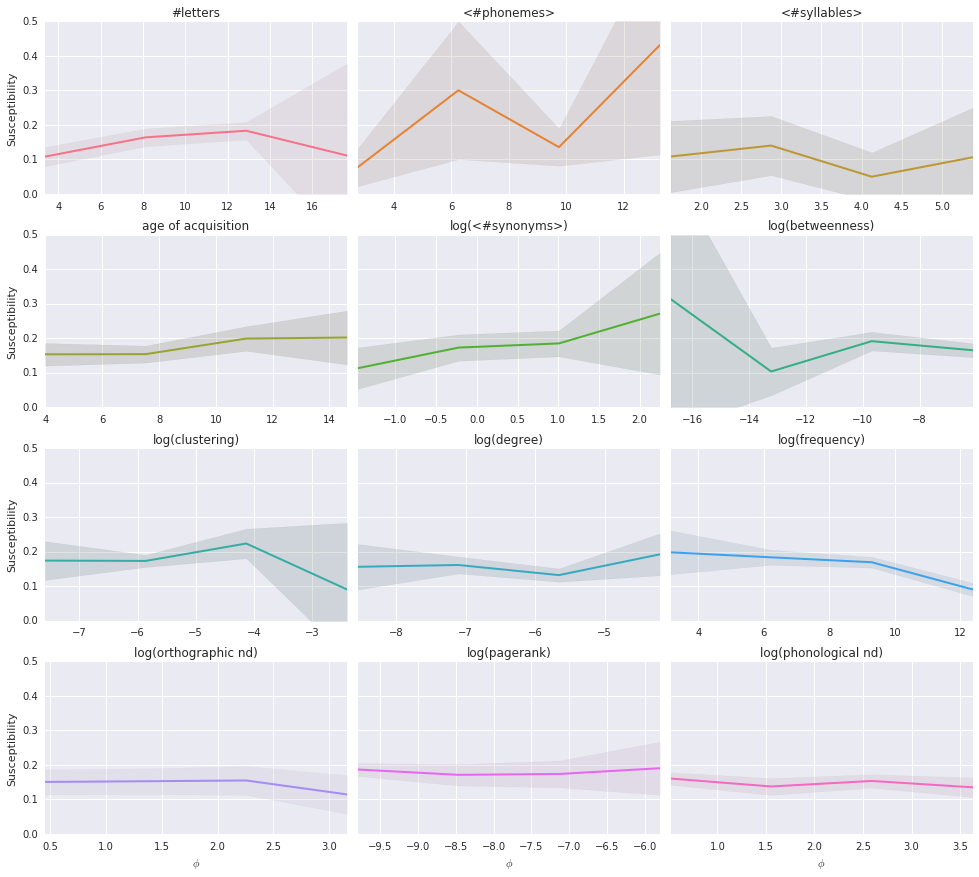

In [7]:
ordered_features = sorted(Substitution.__features__,
                          key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=susties, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

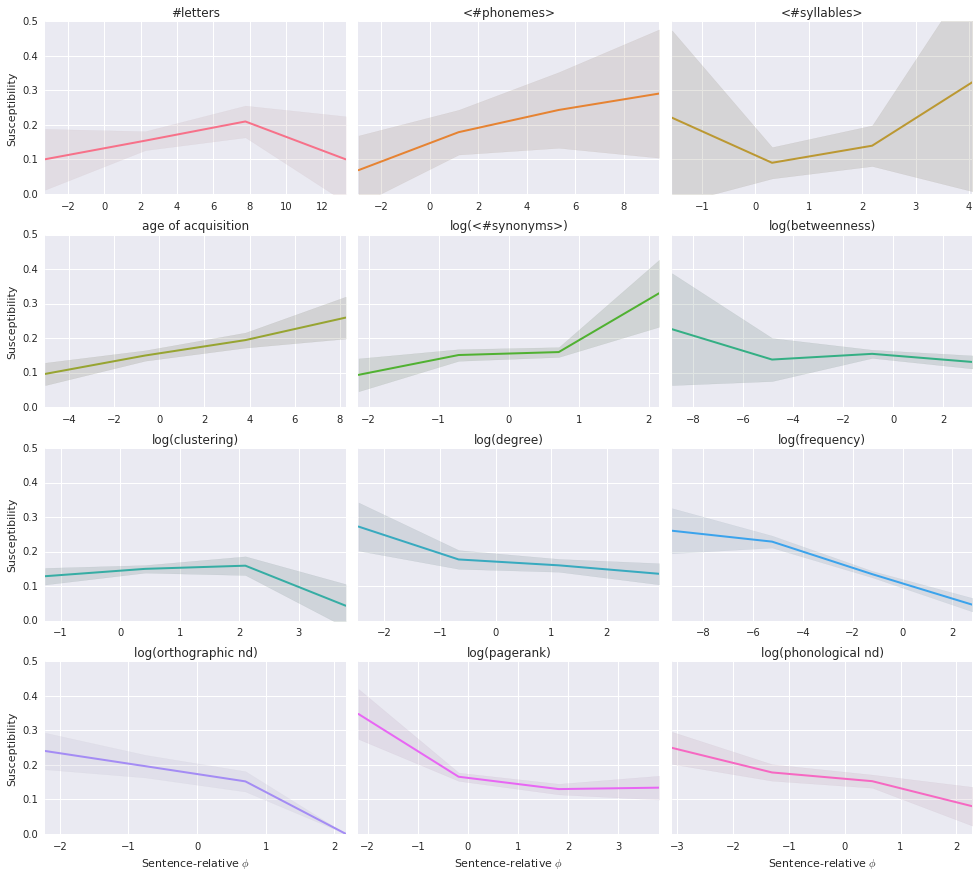

In [8]:
g = sb.FacetGrid(data=susties_rel, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on how confidence intervals are computed here**

There are three ways I can conceive of the computation represented in the graphs above:
1. For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.
2. Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. This is the way CIs are computed above.
3. Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values. So for now I'm sticking with (2).

### 2.2 Feature susceptibilities, reduced to features we expose in the paper

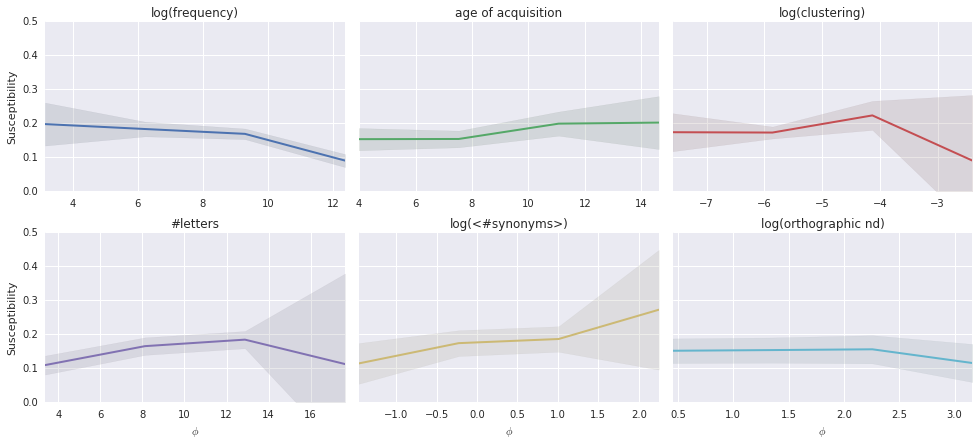

In [9]:
g = sb.FacetGrid(data=susties[susties['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

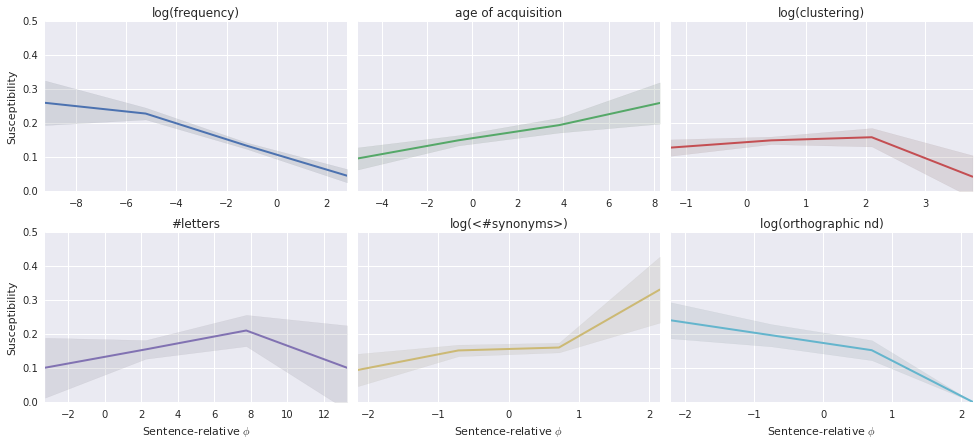

In [10]:
g = sb.FacetGrid(data=susties_rel[susties_rel['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

## 3 On which POS tags do substitutions fall?

In [11]:
poses = susty_words[susty_words.feature == 'aoa'][['POS', 'cluster_id', 'destination_id',
                                                   'occurrence', 'source_id', 'target',
                                                   'weight', 'weight_appeared', 'word']]
# Only take first letter of POS code to denote categories,
# and group stopword-like categories together.
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']
poses['rPOS'] = poses['POS']\
    .apply(lambda x: x[0])\
    .apply(lambda x: 'Stopword-like' if x in stop_poses else x)

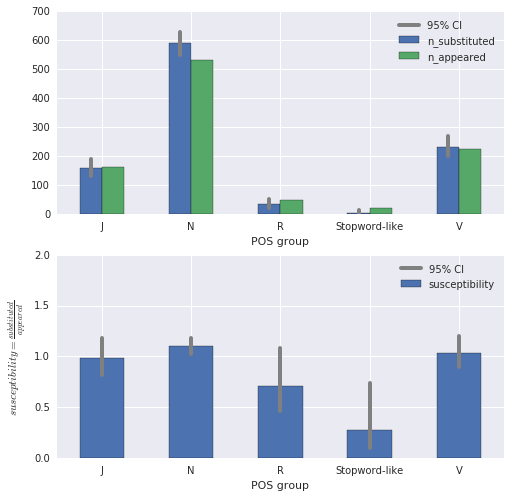

In [12]:
# Compute POS counts.
susty_pos = lambda x: ((x * poses.loc[x.index, 'weight']).sum() /
                       poses.loc[x.index, 'weight_appeared'].sum())
susties_pos = poses.groupby('rPOS')['target'].aggregate(
    {'susceptibility': susty_pos,
     'n_substituted': lambda x: (x * poses.loc[x.index, 'weight']).sum(),
     'n_appeared': lambda x: poses.loc[x.index, 'weight_appeared'].sum()}
).rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']].plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(), method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted, lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility'].plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], cis[i] * total_substituted / susties_pos.n_appeared.iloc[i],
                 lw=4, color='grey', label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-pos_susceptibilities'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [13]:
# Test the n_substituted proportions are different from the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['N', 'Stopword-like']


## 4 Susceptibility in terms of absolute fractiles

In [14]:
def plot_absolute_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')

    # Compute feature bins.
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            x_fractiles = pd.qcut(data.value, bin_count, labels=False)
            break
        except ValueError:
            pass

    # Compute bin counts
    heights = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = data[data.target & (x_fractiles == i)].weight.sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, bin_count + 1), heights, color=color)
    plt.fill_between(range(1, bin_count + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, bin_count + 1))
    plt.xlim(1, bin_count)
    plt.ylim(0, None)

### 4.1 All features susceptibilities

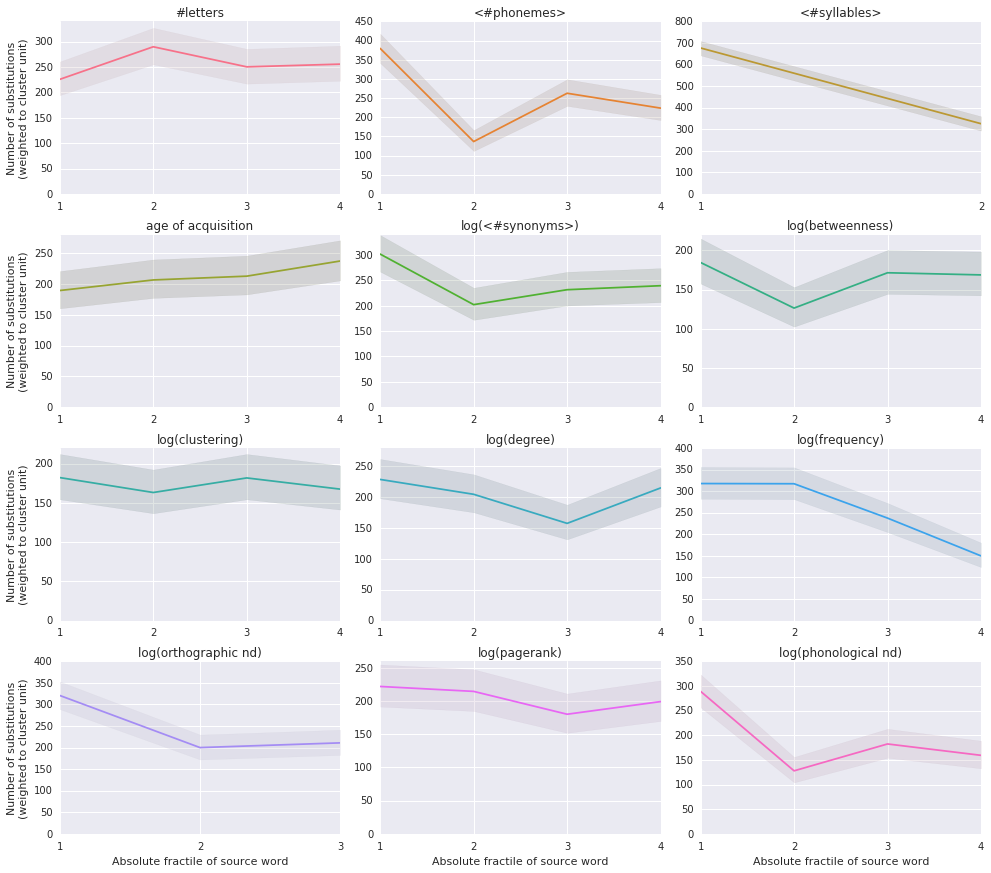

In [15]:
# Now plot.
g = sb.FacetGrid(data=susty_words, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're again in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all absolute feature fractiles are available to sample from in all the sentences. Again, there's no way out of this, so we're going to use multinomial CIs.

### 4.2 Feature susceptibilities, reduced to features we expose in the paper

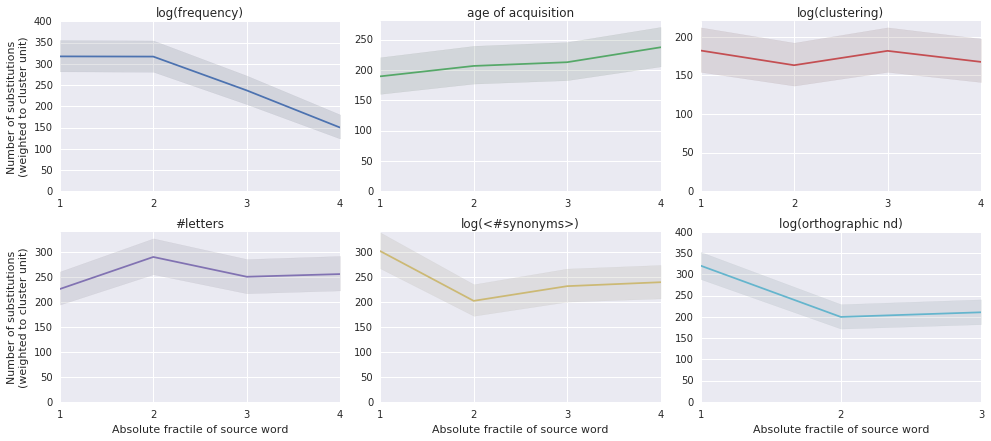

In [16]:
# Now plot.
g = sb.FacetGrid(data=susty_words[susty_words['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

## 5 Susceptibility in terms of sentence fractiles

Build our data.

In [17]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, _ = substitution.features(feature)
            if np.isnan(source):
                # The source word has no feature value. We drop this substitution.
                continue
            sentence, _ = substitution.source_destination_features(feature)
            # Remove stopwords from this analysis, since we dropped substitutions on stopwords.
            dslice = slice(substitution.start,
                           substitution.start + len(substitution.destination.tokens))
            is_stopword = np.array([(lemma in stopwords) or (token in stopwords)
                                    for (lemma, token) in
                                    zip(substitution.source.lemmas[dslice],
                                        substitution.source.tokens[dslice])])
            sentence[is_stopword] = np.nan
            # Find the number of bins we'll use.
            values = set(sentence[np.isfinite(sentence)])
            if len(values) == 0 or len(values) == 1:
                # Only NaNs, or only one feature value. Drop this.
                continue
            start, stop = None, None
            power = 0
            while start is None:
                if int(BIN_COUNT / 2**power) * 2**power != BIN_COUNT:
                    raise ValueError('BIN_COUNT must be a power of 2')
                try:
                    start = 2**power * pd.qcut(sentence, int(BIN_COUNT / 2**power),
                                               labels=False)[substitution.position]
                    stop = start + 2**power
                except ValueError:
                    power += 1
            # And finally save the bin.
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'start': start,
                         'stop': stop})

original_fractiles = pd.DataFrame(data)
del data

  0% (  69 of 9180) |                      | Elapsed Time: 0:00:01 ETA:  0:02:12

  1% ( 115 of 9180) |                      | Elapsed Time: 0:00:01 ETA:  0:02:17

  2% ( 184 of 9180) |                      | Elapsed Time: 0:00:02 ETA:  0:02:13

  2% ( 230 of 9180) |                      | Elapsed Time: 0:00:03 ETA:  0:02:13

  3% ( 309 of 9180) |                      | Elapsed Time: 0:00:04 ETA:  0:02:06

  3% ( 345 of 9180) |                      | Elapsed Time: 0:00:04 ETA:  0:02:03

  4% ( 422 of 9180) |#                     | Elapsed Time: 0:00:05 ETA:  0:02:00

  5% ( 459 of 9180) |#                     | Elapsed Time: 0:00:06 ETA:  0:01:58

  5% ( 535 of 9180) |#                     | Elapsed Time: 0:00:07 ETA:  0:01:56

  6% ( 574 of 9180) |#                     | Elapsed Time: 0:00:07 ETA:  0:01:57

  7% ( 645 of 9180) |#                     | Elapsed Time: 0:00:08 ETA:  0:01:55

  7% ( 689 of 9180) |#                     | Elapsed Time: 0:00:09 ETA:  0:01:55

  8% ( 746 of 9180) |#                     | Elapsed Time: 0:00:10 ETA:  0:01:57

  8% ( 804 of 9180) |#                     | Elapsed Time: 0:00:11 ETA:  0:02:06

  9% ( 861 of 9180) |##                    | Elapsed Time: 0:00:12 ETA:  0:02:11

 10% ( 918 of 9180) |##                    | Elapsed Time: 0:00:13 ETA:  0:02:15

 10% ( 975 of 9180) |##                    | Elapsed Time: 0:00:14 ETA:  0:02:20

 11% (1033 of 9180) |##                    | Elapsed Time: 0:00:15 ETA:  0:02:19

 12% (1107 of 9180) |##                    | Elapsed Time: 0:00:16 ETA:  0:02:17

 12% (1148 of 9180) |##                    | Elapsed Time: 0:00:17 ETA:  0:02:16

 13% (1213 of 9180) |##                    | Elapsed Time: 0:00:18 ETA:  0:02:12

 13% (1263 of 9180) |###                   | Elapsed Time: 0:00:19 ETA:  0:02:06

 14% (1340 of 9180) |###                   | Elapsed Time: 0:00:20 ETA:  0:02:01

 15% (1377 of 9180) |###                   | Elapsed Time: 0:00:20 ETA:  0:01:56

 15% (1443 of 9180) |###                   | Elapsed Time: 0:00:21 ETA:  0:01:53

 16% (1492 of 9180) |###                   | Elapsed Time: 0:00:22 ETA:  0:01:52

 16% (1557 of 9180) |###                   | Elapsed Time: 0:00:23 ETA:  0:01:52

 17% (1607 of 9180) |###                   | Elapsed Time: 0:00:24 ETA:  0:01:56

 18% (1675 of 9180) |####                  | Elapsed Time: 0:00:25 ETA:  0:01:54

 18% (1722 of 9180) |####                  | Elapsed Time: 0:00:26 ETA:  0:01:56

 19% (1787 of 9180) |####                  | Elapsed Time: 0:00:27 ETA:  0:01:55

 20% (1836 of 9180) |####                  | Elapsed Time: 0:00:27 ETA:  0:01:57

 20% (1910 of 9180) |####                  | Elapsed Time: 0:00:28 ETA:  0:01:56

 21% (1951 of 9180) |####                  | Elapsed Time: 0:00:29 ETA:  0:01:55

 21% (2014 of 9180) |####                  | Elapsed Time: 0:00:30 ETA:  0:01:52

 22% (2066 of 9180) |####                  | Elapsed Time: 0:00:31 ETA:  0:01:50

 23% (2142 of 9180) |#####                 | Elapsed Time: 0:00:32 ETA:  0:01:43

 23% (2181 of 9180) |#####                 | Elapsed Time: 0:00:32 ETA:  0:01:41

 24% (2251 of 9180) |#####                 | Elapsed Time: 0:00:33 ETA:  0:01:37

 25% (2295 of 9180) |#####                 | Elapsed Time: 0:00:34 ETA:  0:01:35

 25% (2378 of 9180) |#####                 | Elapsed Time: 0:00:35 ETA:  0:01:31

 26% (2410 of 9180) |#####                 | Elapsed Time: 0:00:35 ETA:  0:01:30

 27% (2489 of 9180) |#####                 | Elapsed Time: 0:00:36 ETA:  0:01:28

 27% (2525 of 9180) |######                | Elapsed Time: 0:00:37 ETA:  0:01:24

 28% (2602 of 9180) |######                | Elapsed Time: 0:00:38 ETA:  0:01:23

 28% (2640 of 9180) |######                | Elapsed Time: 0:00:38 ETA:  0:01:22

 29% (2724 of 9180) |######                | Elapsed Time: 0:00:39 ETA:  0:01:20

 30% (2754 of 9180) |######                | Elapsed Time: 0:00:40 ETA:  0:01:18

 30% (2830 of 9180) |######                | Elapsed Time: 0:00:41 ETA:  0:01:16

 31% (2869 of 9180) |######                | Elapsed Time: 0:00:41 ETA:  0:01:18

 32% (2942 of 9180) |#######               | Elapsed Time: 0:00:42 ETA:  0:01:17

 32% (2984 of 9180) |#######               | Elapsed Time: 0:00:43 ETA:  0:01:18

 33% (3057 of 9180) |#######               | Elapsed Time: 0:00:44 ETA:  0:01:17

 33% (3099 of 9180) |#######               | Elapsed Time: 0:00:45 ETA:  0:01:18

 34% (3176 of 9180) |#######               | Elapsed Time: 0:00:46 ETA:  0:01:17

 35% (3213 of 9180) |#######               | Elapsed Time: 0:00:46 ETA:  0:01:20

 35% (3267 of 9180) |#######               | Elapsed Time: 0:00:47 ETA:  0:01:23

 36% (3328 of 9180) |#######               | Elapsed Time: 0:00:48 ETA:  0:01:25

 37% (3400 of 9180) |########              | Elapsed Time: 0:00:49 ETA:  0:01:24

 37% (3443 of 9180) |########              | Elapsed Time: 0:00:50 ETA:  0:01:25

 37% (3487 of 9180) |########              | Elapsed Time: 0:00:51 ETA:  0:01:42

 38% (3558 of 9180) |########              | Elapsed Time: 0:00:52 ETA:  0:01:41

 39% (3621 of 9180) |########              | Elapsed Time: 0:00:53 ETA:  0:01:41

 40% (3672 of 9180) |########              | Elapsed Time: 0:00:54 ETA:  0:01:45

 40% (3745 of 9180) |########              | Elapsed Time: 0:00:55 ETA:  0:01:41

 41% (3787 of 9180) |#########             | Elapsed Time: 0:00:56 ETA:  0:01:36

 42% (3866 of 9180) |#########             | Elapsed Time: 0:00:57 ETA:  0:01:31

 42% (3902 of 9180) |#########             | Elapsed Time: 0:00:57 ETA:  0:01:31

 43% (3967 of 9180) |#########             | Elapsed Time: 0:00:58 ETA:  0:01:30

 43% (4017 of 9180) |#########             | Elapsed Time: 0:00:59 ETA:  0:01:11

 44% (4084 of 9180) |#########             | Elapsed Time: 0:01:00 ETA:  0:01:11

 45% (4131 of 9180) |#########             | Elapsed Time: 0:01:01 ETA:  0:01:09

 45% (4208 of 9180) |##########            | Elapsed Time: 0:01:02 ETA:  0:01:05

 46% (4246 of 9180) |##########            | Elapsed Time: 0:01:02 ETA:  0:01:04

 46% (4307 of 9180) |##########            | Elapsed Time: 0:01:03 ETA:  0:01:06

 47% (4361 of 9180) |##########            | Elapsed Time: 0:01:04 ETA:  0:01:07

 48% (4428 of 9180) |##########            | Elapsed Time: 0:01:05 ETA:  0:01:08

 48% (4476 of 9180) |##########            | Elapsed Time: 0:01:06 ETA:  0:01:15

 49% (4550 of 9180) |##########            | Elapsed Time: 0:01:07 ETA:  0:01:11

 50% (4590 of 9180) |###########           | Elapsed Time: 0:01:08 ETA:  0:01:10

 50% (4662 of 9180) |###########           | Elapsed Time: 0:01:09 ETA:  0:01:11

 51% (4705 of 9180) |###########           | Elapsed Time: 0:01:09 ETA:  0:01:10

 52% (4778 of 9180) |###########           | Elapsed Time: 0:01:10 ETA:  0:01:05

 52% (4820 of 9180) |###########           | Elapsed Time: 0:01:11 ETA:  0:01:05

 53% (4905 of 9180) |###########           | Elapsed Time: 0:01:12 ETA:  0:00:59

 53% (4935 of 9180) |###########           | Elapsed Time: 0:01:12 ETA:  0:00:50

 54% (5020 of 9180) |############          | Elapsed Time: 0:01:13 ETA:  0:00:45

 55% (5049 of 9180) |############          | Elapsed Time: 0:01:14 ETA:  0:00:46

 55% (5134 of 9180) |############          | Elapsed Time: 0:01:15 ETA:  0:00:43

 56% (5164 of 9180) |############          | Elapsed Time: 0:01:15 ETA:  0:00:41

 57% (5241 of 9180) |############          | Elapsed Time: 0:01:16 ETA:  0:00:40

 57% (5279 of 9180) |############          | Elapsed Time: 0:01:17 ETA:  0:00:40

 58% (5353 of 9180) |############          | Elapsed Time: 0:01:18 ETA:  0:00:39

 58% (5394 of 9180) |############          | Elapsed Time: 0:01:18 ETA:  0:00:41

 59% (5471 of 9180) |#############         | Elapsed Time: 0:01:19 ETA:  0:00:41

 60% (5508 of 9180) |#############         | Elapsed Time: 0:01:20 ETA:  0:00:42

 60% (5585 of 9180) |#############         | Elapsed Time: 0:01:21 ETA:  0:00:40

 61% (5623 of 9180) |#############         | Elapsed Time: 0:01:21 ETA:  0:00:41

 62% (5698 of 9180) |#############         | Elapsed Time: 0:01:22 ETA:  0:00:39

 62% (5738 of 9180) |#############         | Elapsed Time: 0:01:23 ETA:  0:00:40

 63% (5817 of 9180) |#############         | Elapsed Time: 0:01:24 ETA:  0:00:37

 63% (5853 of 9180) |##############        | Elapsed Time: 0:01:24 ETA:  0:00:36

 65% (5967 of 9180) |##############        | Elapsed Time: 0:01:25 ETA:  0:00:28

 65% (6042 of 9180) |##############        | Elapsed Time: 0:01:26 ETA:  0:00:28

 66% (6082 of 9180) |##############        | Elapsed Time: 0:01:27 ETA:  0:00:26

 67% (6158 of 9180) |##############        | Elapsed Time: 0:01:28 ETA:  0:00:27

 67% (6197 of 9180) |##############        | Elapsed Time: 0:01:28 ETA:  0:00:26

 68% (6276 of 9180) |###############       | Elapsed Time: 0:01:29 ETA:  0:00:24

 68% (6312 of 9180) |###############       | Elapsed Time: 0:01:30 ETA:  0:00:24

 69% (6388 of 9180) |###############       | Elapsed Time: 0:01:31 ETA:  0:00:24

 70% (6426 of 9180) |###############       | Elapsed Time: 0:01:31 ETA:  0:00:26

 70% (6513 of 9180) |###############       | Elapsed Time: 0:01:32 ETA:  0:00:24

 71% (6541 of 9180) |###############       | Elapsed Time: 0:01:33 ETA:  0:00:24

 72% (6611 of 9180) |###############       | Elapsed Time: 0:01:34 ETA:  0:00:25

 72% (6656 of 9180) |###############       | Elapsed Time: 0:01:34 ETA:  0:00:25

 73% (6736 of 9180) |################      | Elapsed Time: 0:01:35 ETA:  0:00:23

 73% (6771 of 9180) |################      | Elapsed Time: 0:01:36 ETA:  0:00:21

 74% (6849 of 9180) |################      | Elapsed Time: 0:01:37 ETA:  0:00:20

 75% (6885 of 9180) |################      | Elapsed Time: 0:01:37 ETA:  0:00:19

 75% (6959 of 9180) |################      | Elapsed Time: 0:01:38 ETA:  0:00:20

 76% (7000 of 9180) |################      | Elapsed Time: 0:01:39 ETA:  0:00:21

 77% (7077 of 9180) |################      | Elapsed Time: 0:01:40 ETA:  0:00:20

 77% (7115 of 9180) |#################     | Elapsed Time: 0:01:40 ETA:  0:00:19

 78% (7195 of 9180) |#################     | Elapsed Time: 0:01:41 ETA:  0:00:16

 78% (7230 of 9180) |#################     | Elapsed Time: 0:01:42 ETA:  0:00:16

 79% (7304 of 9180) |#################     | Elapsed Time: 0:01:43 ETA:  0:00:17

 80% (7344 of 9180) |#################     | Elapsed Time: 0:01:43 ETA:  0:00:20

 80% (7421 of 9180) |#################     | Elapsed Time: 0:01:44 ETA:  0:00:19

 81% (7459 of 9180) |#################     | Elapsed Time: 0:01:45 ETA:  0:00:20

 82% (7534 of 9180) |##################    | Elapsed Time: 0:01:46 ETA:  0:00:19

 82% (7574 of 9180) |##################    | Elapsed Time: 0:01:47 ETA:  0:00:19

 83% (7654 of 9180) |##################    | Elapsed Time: 0:01:48 ETA:  0:00:15

 83% (7689 of 9180) |##################    | Elapsed Time: 0:01:48 ETA:  0:00:17

 84% (7775 of 9180) |##################    | Elapsed Time: 0:01:49 ETA:  0:00:14

 85% (7803 of 9180) |##################    | Elapsed Time: 0:01:49 ETA:  0:00:13

 85% (7883 of 9180) |##################    | Elapsed Time: 0:01:50 ETA:  0:00:08

 86% (7918 of 9180) |##################    | Elapsed Time: 0:01:51 ETA:  0:00:06

 87% (8005 of 9180) |###################   | Elapsed Time: 0:01:52 ETA:  0:00:01

 87% (8033 of 9180) |###################   | Elapsed Time: 0:01:52 ETA:  0:00:00

 88% (8109 of 9180) |###################   | Elapsed Time: 0:01:53 ETA:  0:00:00

 88% (8148 of 9180) |###################   | Elapsed Time: 0:01:54 ETA:  0:00:00

 89% (8225 of 9180) |###################   | Elapsed Time: 0:01:55 ETA:  0:00:00

 90% (8262 of 9180) |###################   | Elapsed Time: 0:01:55 ETA:  0:00:00

 90% (8340 of 9180) |###################   | Elapsed Time: 0:01:56 ETA:  0:00:00

 91% (8377 of 9180) |####################  | Elapsed Time: 0:01:57 ETA:  0:00:00

 92% (8457 of 9180) |####################  | Elapsed Time: 0:01:58 ETA:  0:00:00

 92% (8492 of 9180) |####################  | Elapsed Time: 0:01:58 ETA:  0:00:00

 93% (8571 of 9180) |####################  | Elapsed Time: 0:01:59 ETA:  0:00:00

 93% (8607 of 9180) |####################  | Elapsed Time: 0:02:00 ETA:  0:00:00

 94% (8685 of 9180) |####################  | Elapsed Time: 0:02:01 ETA:  0:00:00

 95% (8721 of 9180) |####################  | Elapsed Time: 0:02:01 ETA:  0:00:00

 95% (8804 of 9180) |##################### | Elapsed Time: 0:02:02 ETA:  0:00:00

 96% (8836 of 9180) |##################### | Elapsed Time: 0:02:02 ETA:  0:00:00

 97% (8917 of 9180) |##################### | Elapsed Time: 0:02:03 ETA:  0:00:00

 97% (8951 of 9180) |##################### | Elapsed Time: 0:02:04 ETA:  0:00:00

 98% (9025 of 9180) |##################### | Elapsed Time: 0:02:05 ETA:  0:00:00

 98% (9066 of 9180) |##################### | Elapsed Time: 0:02:06 ETA:  0:00:00

 99% (9149 of 9180) |##################### | Elapsed Time: 0:02:07 ETA:  0:00:00

100% (9180 of 9180) |######################| Elapsed Time: 0:02:07 Time: 0:02:07


Compute the weight of each substitution, according to what other substitutions it's pooled with, and the size of its bin. Letting:
* $n_d(i) = \#\text{substitutions with same durl as substitution }i$
* and $n_c(i) = \#\text{substitutions with same cluster as substitution }i$ (counting substitutions with the same durl as one)
* $p(i) = \text{precision (width) of the bin we assigned to substitution }i$

Then we define the weight of a substitution $i$:
$$w(i) = \frac{1}{n_d(i) n_c(i) p(i)}$$

In [18]:
fractiles = original_fractiles.copy()
divide_sum = lambda x: x / x.sum()

# Weight is 1 at first.
fractiles['weight'] = 1
# Divided by the number of substitutions that share a durl.
fractiles['weight'] = fractiles\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
fractiles['weight'] = fractiles\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_sum)
# And finally divide by the precision of the bin we put a substitution in.
fractiles['weight'] = fractiles['weight'] / (fractiles['stop'] - fractiles['start'])

Now for each feature, count the sum of weights in each bin and plot that.

In [19]:
def plot_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = data[(data['start'] <= i) & (i < data['stop'])]['weight'].sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, BIN_COUNT + 1), heights, color=color)
    plt.fill_between(range(1, BIN_COUNT + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, BIN_COUNT + 1))
    plt.ylim(0, None)

### 5.1 All features susceptibilities

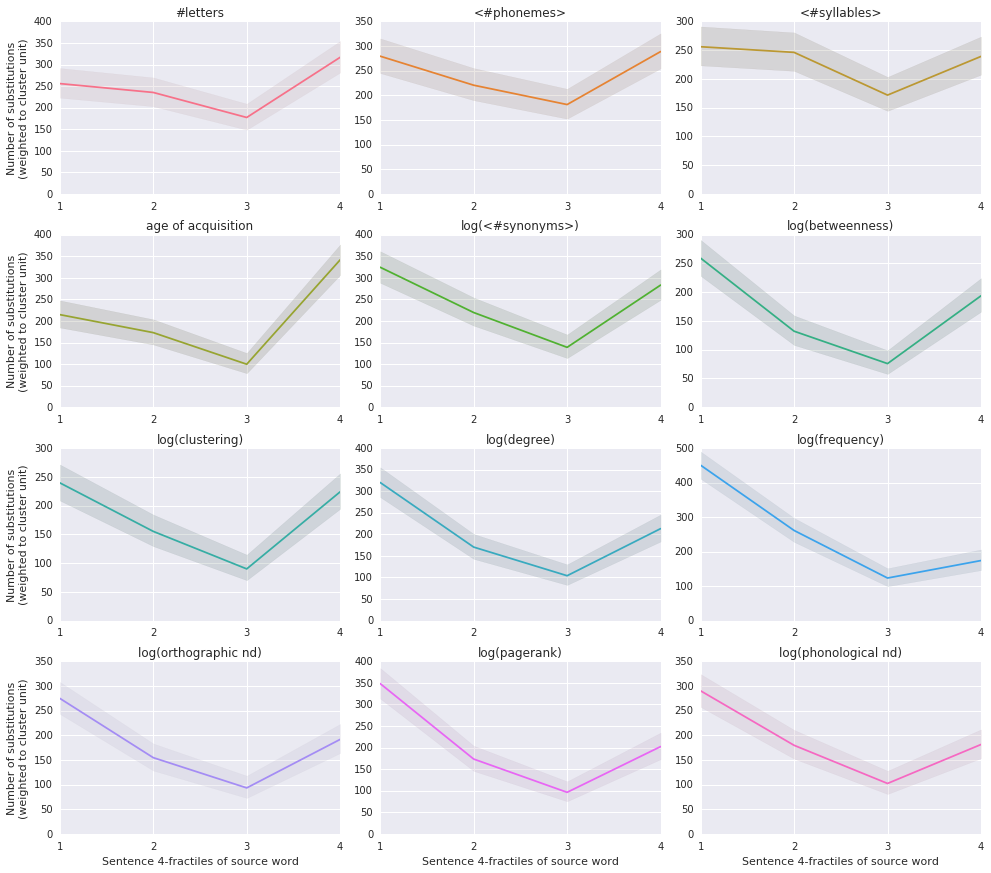

In [20]:
# Now plot.
g = sb.FacetGrid(data=fractiles, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're finally in a real multinomial sampling (and it's the only time). So we're going to use multinomial CIs.

### 5.2 Feature susceptibilities, reduced to features we expose in the paper

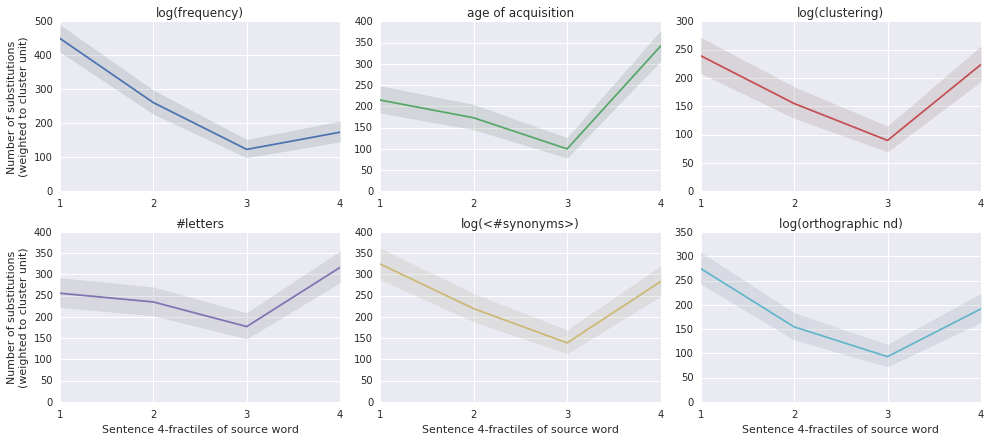

In [21]:
# Now plot.
g = sb.FacetGrid(data=fractiles[fractiles['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)